In [1]:
import sys

import nltk

nltk.download(["punkt", "wordnet"])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

import re

import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elun1c0rn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elun1c0rn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data(database_filepath):
    """
    Loads the data from the database and splits into the message values and the categories.

    Parameters:
    database_filepath (str): The path to the sqlite database file.

    Returns:
    X: The values for the messages column of the 'disaster_messages' table.
    Y: The values for the categorical columns of the 'disaster_messages' table.
    category_names: The names of the categorical columns.
    """
    # Create the engine
    engine = create_engine(f"sqlite:///{database_filepath}")
    # Load the data in a pandas Dataframe
    df = pd.read_sql_table("disaster_messages", engine)

    # Gets the values for the 'message' column
    X = df.message.values
    # These are the categorical columns in the dataset. Excluding the categories that have only one value.
    category_names = [ cn for cn in df.columns[4:] if df[cn].nunique() > 1 ]
    # Our Y should be only the part of the dataframe that contains the categories and the values for each record.
    Y = df[category_names].values

    return X, Y, category_names

In [3]:
def tokenize(text):
    """
    Tokenizes a string of text. Changes the case to lower case and removes any non-alphanumeric characters.

    Parameters:
    text (str): The string of text to clean and separate into tokens.

    Returns:
    list: A list of cleaned tokens for the input text.
    """
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [4]:
def build_model():
    """
    Builds the model using a pipeline.

    Parameters:
    text (str): The string of text to clean and separate into tokens.

    Returns:
    list: A list of cleaned tokens for the input text.
    """
    base_model = Pipeline([
        ( 'vect', HashingVectorizer( tokenizer=tokenize, token_pattern=None) ), 
        ( 'clf', MultiOutputClassifier( LinearSVC(dual='auto') ) )
    ])

    # parameters = {
    #     'vect__ngram_range': ((1, 1), (1, 2)),
    #     'clf__estimator__C': [ 0.1, 1, 10 ], 
    #     'clf__estimator__max_iter': [1000, 2000, 3000],
    #     'clf__estimator__penalty': ['l1', 'l2']
    # }

    parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__penalty': ['l1', 'l2']
    }

    scoring = {
        'f1': 'f1_weighted',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'accuracy': 'accuracy'
    }

    model = GridSearchCV(base_model, param_grid=parameters, verbose=2, n_jobs=-1, refit='accuracy', scoring=scoring, return_train_score=True)
    return model

In [5]:
def evaluate_model(model, X_test, Y_test, category_names):
    """
    Calculates the accuracy, precision, and recall for the model based on the test data.

    Parameters:
    model: The model to evaluate.
    X_test: The test data to evaluate the model on.
    Y_test: The true values for the test data.
    category_names: The names of the categories in the dataset.

    Returns:
    list: A list of cleaned tokens for the input text.
    """
    Y_pred = model.predict(X_test)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    max_len = max( [ len(cn) for cn in category_names ] )

    for col_idx, cn in enumerate(category_names):
        report = classification_report( Y_test[:, col_idx], Y_pred[:, col_idx], zero_division=np.nan, output_dict=True )
        col_acc = report['accuracy']
        col_prec = report['macro avg']['precision']
        col_recl = report['macro avg']['recall']
        col_f1 = report['macro avg']['f1-score']

        accuracy_scores.append( col_acc )
        precision_scores.append( col_prec )
        recall_scores.append( col_recl )
        f1_scores.append( col_f1 )

    #     print( f"\t{cn.rjust(max_len, ' ')}: Accuracy: {col_acc:.2f} Precision: {col_prec:.2f} Recall: {col_recl:.2f} F1 Score: {col_f1:.2f}" )

    # print( "\t--- Overall Averaged Scores ---" )
    # print( f"\tAccuracy: {np.mean(accuracy_scores):.2f}" )
    # print( f"\tPrecision: {np.mean(precision_scores):.2f}" )
    # print( f"\tRecall: {np.mean(recall_scores):.2f}" )
    # print( f"\tF1: {np.mean(f1_scores):.2f}" )
    # print()

    print( model.best_score_ )

    return model

In [6]:
def save_model(model, model_filepath):
    """
    Builds the model using a pipeline.

    Parameters:
    model (obj): The model that we have trained.
    model_filepath (str): The path for where to save the model as a pickle file.
    """
    pickle.dump(model, open(model_filepath, "wb"))

In [7]:
database_filepath = '../data/DisasterResponse.db'
model_filepath = 'model.pkl'

print("Loading data...\n    DATABASE: {}".format(database_filepath))
X, Y, category_names = load_data(database_filepath)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print("Building model...")
model = build_model()

print("Training model...")
model.fit(X_train, Y_train)

print("Evaluating model...")
cv = evaluate_model(model, X_test, Y_test, category_names)

# print("Saving model...\n    MODEL: {}".format(model_filepath))
# save_model(model, model_filepath)

# print("Trained model saved!")

Loading data...
    DATABASE: ../data/DisasterResponse.db
Building model...
Training model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Evaluating model...
0.3114149903687827


In [24]:
results = cv.cv_results_

scoring = {
    'f1': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'accuracy': 'accuracy'
}

for scorer in sorted(scoring.keys()):
    print( f"Scorer: {scorer}" )
    for key, value in results.items():
        if key.startswith(f'mean_test_{scorer}'):
            print( f"{key}: {value}" )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    print( f"Best Score: {best_score}" )
    print( f"Best Params: {results['params'][best_index]}" )

# for key, value in results.items():
#     if key.startswith('mean_test_'):
#         print( f"{key}: {value}" )

#     best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
#     best_score = results["mean_test_%s" % scorer][best_index]

Scorer: accuracy
mean_test_accuracy: [0.30702791 0.31141499 0.30411963 0.30755276]
Best Score: 0.3114149903687827
Best Params: {'clf__estimator__penalty': 'l1', 'vect__ngram_range': (1, 2)}
Scorer: f1
mean_test_f1: [0.64285097 0.64482245 0.63761626 0.63072405]
Best Score: 0.6448224534924825
Best Params: {'clf__estimator__penalty': 'l1', 'vect__ngram_range': (1, 2)}
Scorer: precision
mean_test_precision: [0.75915504 0.76733274 0.76289551 0.77546898]
Best Score: 0.7754689757079432
Best Params: {'clf__estimator__penalty': 'l2', 'vect__ngram_range': (1, 2)}
Scorer: recall
mean_test_recall: [0.59381952 0.59523631 0.58689605 0.57932706]
Best Score: 0.5952363070052229
Best Params: {'clf__estimator__penalty': 'l1', 'vect__ngram_range': (1, 2)}


ValueError: setting an array element with a sequence

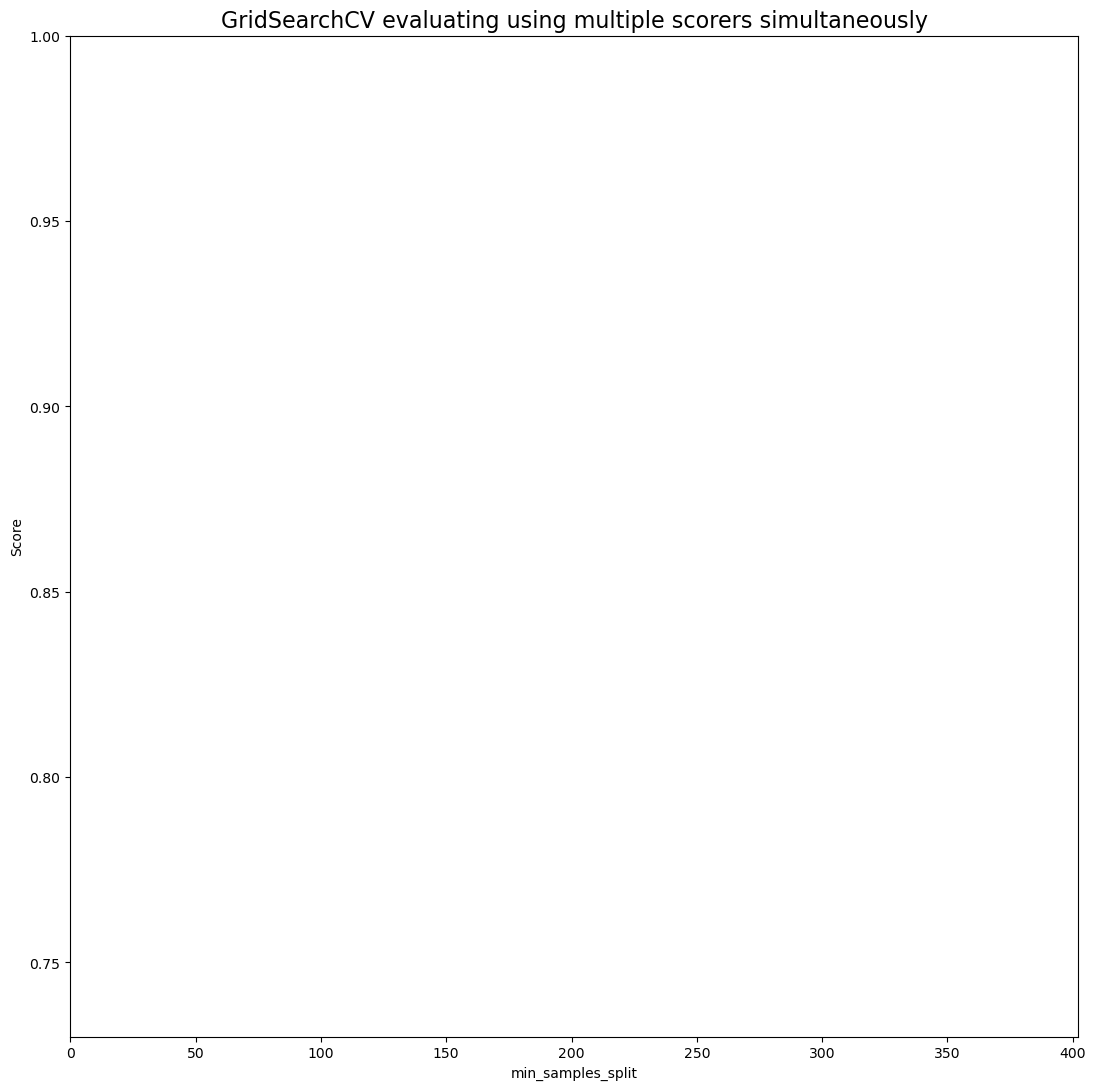

In [19]:
import matplotlib.pyplot as plt

results = cv.cv_results_

scoring = {
    'f1': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'accuracy': 'accuracy'
}

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_vect__ngram_range"].data, dtype=str)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [9]:
for x in cv.cv_results_:
    print(x)
    print(cv.cv_results_[x])
    print()

mean_fit_time
[50.14088392 48.3744153   6.63168664  9.66782041]

std_fit_time
[0.21496705 0.32478413 0.17952983 0.54860042]

mean_score_time
[0.68893228 0.74839954 0.9413445  0.92972069]

std_score_time
[0.0228427  0.02223947 0.13129422 0.06038577]

param_clf__estimator__penalty
['l1' 'l1' 'l2' 'l2']

param_vect__ngram_range
[(1, 1) (1, 2) (1, 1) (1, 2)]

params
[{'clf__estimator__penalty': 'l1', 'vect__ngram_range': (1, 1)}, {'clf__estimator__penalty': 'l1', 'vect__ngram_range': (1, 2)}, {'clf__estimator__penalty': 'l2', 'vect__ngram_range': (1, 1)}, {'clf__estimator__penalty': 'l2', 'vect__ngram_range': (1, 2)}]

split0_test_f1
[0.64014668 0.64246647 0.63366111 0.62529513]

split1_test_f1
[0.64589803 0.6463509  0.63701771 0.63576437]

split2_test_f1
[0.64794646 0.65043998 0.64298458 0.63649461]

split3_test_f1
[0.6424765  0.64453282 0.638765   0.62952152]

split4_test_f1
[0.6377872  0.6403221  0.63565289 0.62654462]

mean_test_f1
[0.64285097 0.64482245 0.63761626 0.63072405]

std_tes